/var/folders/dg/xxhk0_q10fvdkscplvpm64sm0000gp/T/ipykernel_63113/734680918.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/commodity_trade_statistics_data.csv")
/var/folders/dg/xxhk0_q10fvdkscplvpm64sm0000gp/T/ipykernel_63113/734680918.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(top_10_commodities))


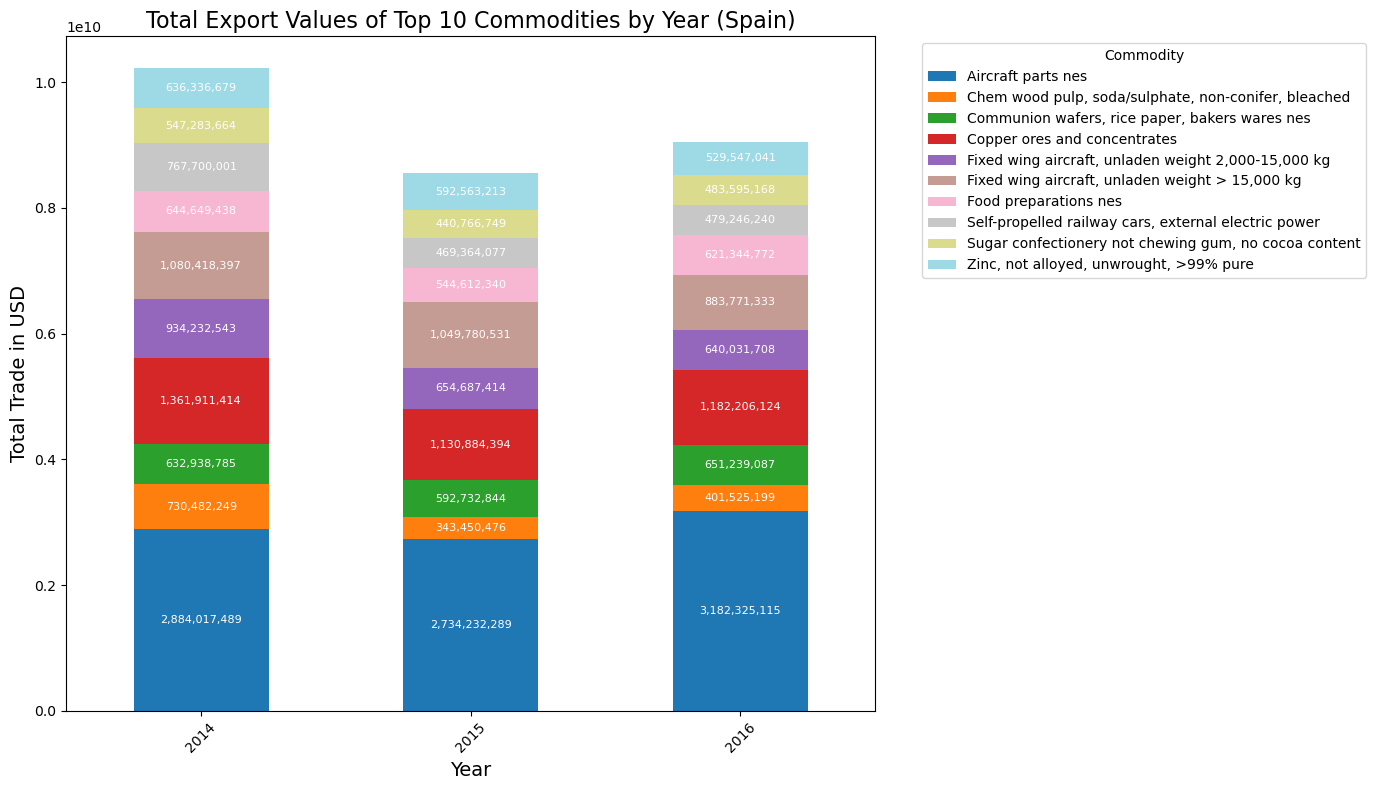

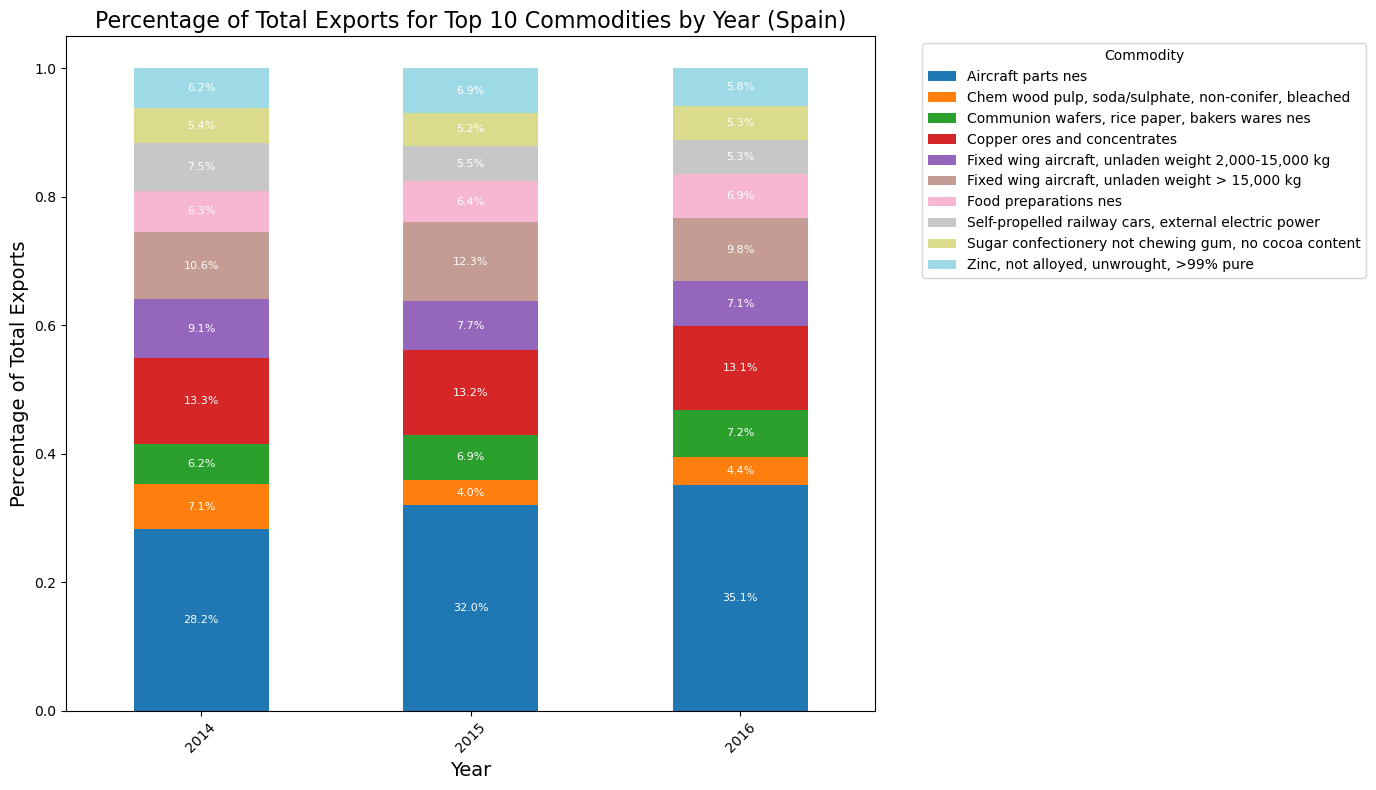

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("data/commodity_trade_statistics_data.csv")

# Filter for Spain and exports
spain_exports = data[(data['country_or_area'] == 'Spain') & (data['flow'] == 'Export')]

# Assuming we want the last 10 years from 2024
current_year = 2024
start_year = current_year - 10
spain_exports_data = spain_exports[(spain_exports['year'] >= start_year) & (spain_exports['year'] <= current_year)]

# Exclude "ALL COMMODITIES" and "Commodities not specified according to kind"
filtered_exports = spain_exports_data[
    (spain_exports_data['commodity'] != 'ALL COMMODITIES') & 
    (spain_exports_data['commodity'] != 'Commodities not specified according to kind')
]

# Aggregate the trade values by commodity across all years
total_exports_by_commodity = filtered_exports.groupby('commodity')['trade_usd'].sum()

# Get the top 10 commodities by total trade amount
top_10_commodities = total_exports_by_commodity.nlargest(10).index.tolist()

# Filter the data to include only these top 10 commodities
top_10_exports = filtered_exports[filtered_exports['commodity'].isin(top_10_commodities)]

# Aggregate the data by year and commodity for plotting
top_10_aggregated_by_year = top_10_exports.groupby(['year', 'commodity'])['trade_usd'].sum().unstack().fillna(0)

# Normalize the data for percentage calculation
top_10_percentages_by_year = top_10_aggregated_by_year.divide(top_10_aggregated_by_year.sum(axis=1), axis=0)

# Define a consistent color palette for the commodities
colors = plt.cm.get_cmap('tab20', len(top_10_commodities))

# Sort the data in ascending order for visualization
sorted_total_values_ascending = top_10_aggregated_by_year.apply(lambda x: x.sort_values(), axis=1)
sorted_percentages_ascending = top_10_percentages_by_year.apply(lambda x: x.sort_values(), axis=1)

# Plot total trade values with labels
fig, ax = plt.subplots(figsize=(14, 8))
bars = sorted_total_values_ascending.plot(kind='bar', stacked=True, ax=ax, color=[colors(i) for i in range(len(top_10_commodities))])
ax.set_title('Total Export Values of Top 10 Commodities by Year (Spain)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Trade in USD', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
for bar in bars.patches:
    bl = bar.get_xy()
    x = 0.5 * bar.get_width() + bl[0]
    y = 0.5 * bar.get_height() + bl[1]
    if bar.get_height() > 1e6:  # Adjust as needed for visibility
        ax.text(x, y, f"{bar.get_height():,.0f}", ha='center', va='center', fontsize=8, color='white')
plt.tight_layout()
plt.show()

# Plot percentages with labels
fig, ax = plt.subplots(figsize=(14, 8))
bars = sorted_percentages_ascending.plot(kind='bar', stacked=True, ax=ax, color=[colors(i) for i in range(len(top_10_commodities))])
ax.set_title('Percentage of Total Exports for Top 10 Commodities by Year (Spain)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percentage of Total Exports', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
for bar in bars.patches:
    bl = bar.get_xy()
    x = 0.5 * bar.get_width() + bl[0]
    y = 0.5 * bar.get_height() + bl[1]
    if bar.get_height() > 0.01:  # Adjust threshold as needed for clarity
        ax.text(x, y, f"{bar.get_height()*100:.1f}%", ha='center', va='center', fontsize=8, color='white')
plt.tight_layout()
plt.show()




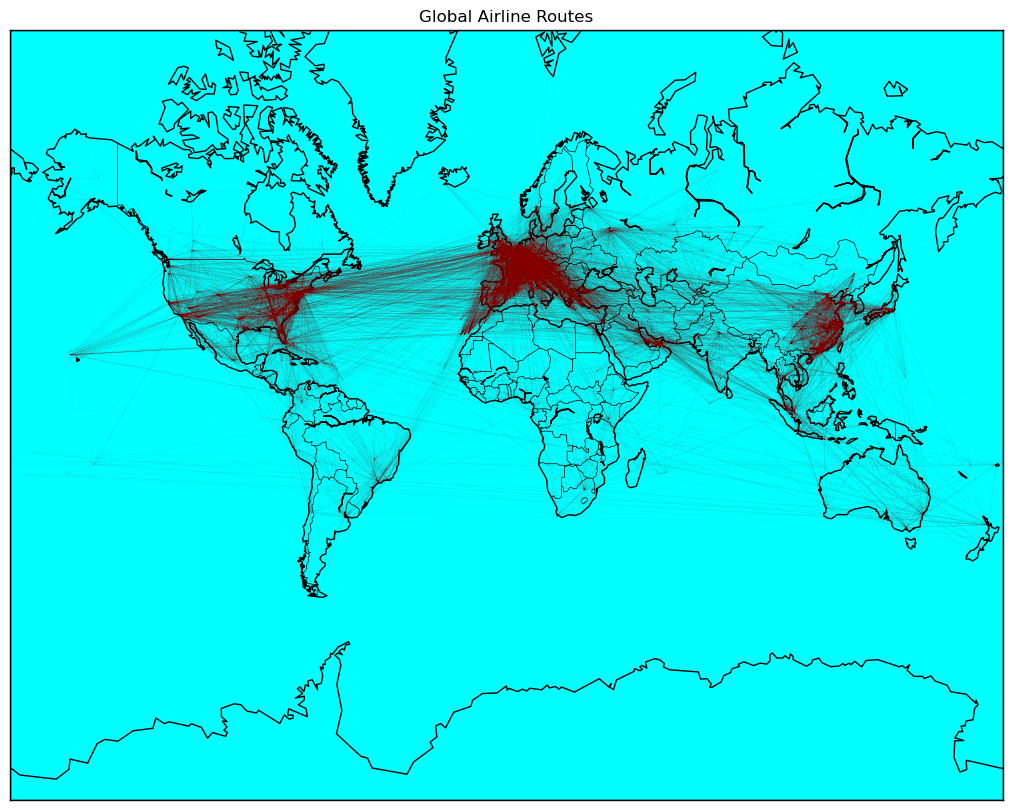

In [5]:
import matplotlib.pyplot as plt
import mpl_toolkits
mpl_toolkits.__path__.append('/usr/lib/python2.7/dist-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap
import pandas as pd

# Load your data
airports_df = pd.read_csv('data/Airports dataset.csv')
routes_df = pd.read_csv('data/Airports Airlines Routes.csv')

# Ensure IDs are integers (if needed)
routes_df['Source airport ID'] = pd.to_numeric(routes_df['Source airport ID'], errors='coerce')
routes_df['Destination airport ID'] = pd.to_numeric(routes_df['Destination airport ID'], errors='coerce')

# Merge data
merged_routes = pd.merge(routes_df, airports_df, left_on='Source airport ID', right_on='Airport ID', how='left')
merged_routes.rename(columns={'Latitude': 'Source Latitude', 'Longitude': 'Source Longitude'}, inplace=True)
merged_routes = pd.merge(merged_routes, airports_df, left_on='Destination airport ID', right_on='Airport ID', how='left', suffixes=('_src', '_dest'))
merged_routes.rename(columns={'Latitude': 'Destination Latitude', 'Longitude': 'Destination Longitude'}, inplace=True)

# Sample data for simplicity
#sampled_routes = merged_routes.sample(n=100, random_state=1)
sampled_routes = merged_routes

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 10))
m = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')

# Plot routes
for _, row in sampled_routes.iterrows():
    x_src, y_src = m(row['Source Longitude'], row['Source Latitude'])
    x_dest, y_dest = m(row['Destination Longitude'], row['Destination Latitude'])
    m.plot([x_src, x_dest], [y_src, y_dest], marker=None, color='red', linewidth=0.3, alpha=0.02)

plt.title('Global Airline Routes')
plt.show()

In [6]:
# Define the project structure as a nested dictionary
project_structure = {
    "my_ds_project": {
        "LICENSE": {},
        "Makefile": {},
        "README.md": {},
        "data": {
            "external": {},
            "interim": {},
            "processed": {},
            "raw": {}
        },
        "docs": {
            "Makefile": {},
            "commands.rst": {},
            "conf.py": {},
            "getting-started.rst": {},
            "index.rst": {},
            "make.bat": {}
        },
        "models": {},
        "notebooks": {},
        "references": {},
        "reports": {
            "figures": {},
        },
        "requirements.txt": {},
        "setup.py": {},
        "src": {
            "__init__.py": {},
            "data": {
                "__init__.py": {},
                "make_dataset.py": {}
            },
            "features": {
                "__init__.py": {},
                "build_features.py": {}
            },
            "models": {
                "__init__.py": {},
                "predict_model.py": {},
                "train_model.py": {}
            },
            "visualization": {
                "__init__.py": {},
                "visualize.py": {}
            }
        },
        "test_environment.py": {},
        "tox.ini": {}
    }
}



In [7]:
from ete3 import Tree, TreeStyle, NodeStyle

# Function to convert dictionary structure into an ETE3 Tree, with style differentiation
def dict_to_tree(structure, name="Root"):
    root = Tree(name=f"{name};")
    is_leaf = not any(isinstance(val, dict) for val in structure.values())  # Check if node is a leaf (file)
    for key, val in structure.items():
        if isinstance(val, dict) and val:  # If directory
            child = dict_to_tree(val, name=key)
            root.add_child(child)
        else:  # If file
            leaf = Tree(name=f"{key};")
            leaf_style = NodeStyle()
            leaf_style["shape"] = "sphere"
            leaf_style["size"] = 10
            leaf_style["fgcolor"] = "blue"  # Color for files
            leaf.set_style(leaf_style)
            root.add_child(leaf)
    if is_leaf:  # Apply different style if the current node is a leaf
        root_style = NodeStyle()
        root_style["shape"] = "sphere"
        root_style["size"] = 10
        root_style["fgcolor"] = "red"  # Different color for directories
        root.set_style(root_style)
    return root


# Create tree from structure
tree = dict_to_tree(project_structure)

# Customizing the tree's appearance
ts = TreeStyle()
ts.mode = "c"  # 'c' for circular tree
ts.show_leaf_name = True
ts.scale = 20  # Scale is 20 pixels per branch length unit
ts.show_scale = False

# Display tree in Jupyter Notebook
tree.show(tree_style=ts)